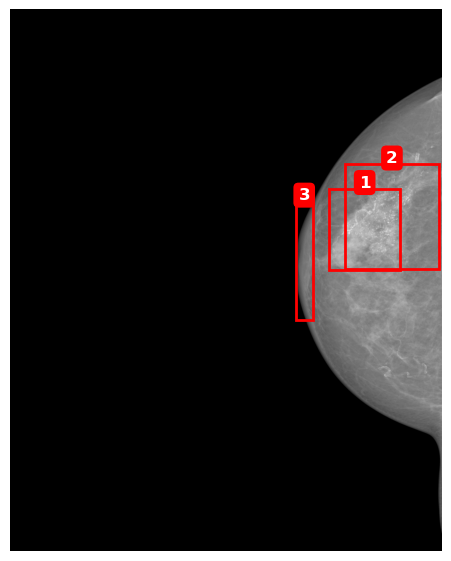

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def mostrar_hallazgos_con_ajuste(image_path, registros, escala=2):
    # Cargar la imagen
    imagen = Image.open(image_path)
    img_width, img_height = imagen.size
    
    # Configurar el tamaño de la figura para reducir el tamaño de la imagen
    dpi = 100  # Densidad de píxeles por pulgada
    fig, ax = plt.subplots(1, figsize=(img_width / (dpi * escala), img_height / (dpi * escala)), dpi=dpi)
    ax.imshow(imagen, cmap="gray")

    # Lista para almacenar los detalles de cada hallazgo
    detalles_hallazgos = []

    for idx, (index, registro) in enumerate(registros.iterrows(), start=1):
        # Verificar si las coordenadas son válidas
        if pd.isna(registro['xmin']) or pd.isna(registro['ymin']) or pd.isna(registro['xmax']) or pd.isna(registro['ymax']):
            print(f"Las coordenadas de la anotación están incompletas para el hallazgo {idx} y serán omitidas.")
            continue

        # Obtener datos del registro y dimensiones originales
        breast_birads = registro['finding_birads']
        breast_density = registro.get('breast_density', 'N/A')
        finding_categories = registro.get('finding_categories', 'N/A')
        xmin = int(registro['xmin'])
        ymin = int(registro['ymin'])
        xmax = int(registro['xmax'])
        ymax = int(registro['ymax'])
        original_height = registro['height']
        original_width = registro['width']
        
        # Escalado de las coordenadas en base a las dimensiones de la imagen
        scale_x = img_width / original_width
        scale_y = img_height / original_height
        
        # Ajustar las coordenadas de acuerdo a la escala calculada
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)

        # Crear el cuadro delimitador en color rojo con grosor
        ancho = xmax - xmin
        alto = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), ancho, alto, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Calcular la posición central superior para el número del hallazgo
        center_x = xmin + ancho / 2
        text_y = ymin - 10  # Ajustar el texto ligeramente arriba de ymin
        
        # Añadir el número de hallazgo en el cuadro, centrado en la parte superior
        ax.text(center_x, text_y, f"{idx}", color="white", fontsize=12, weight="bold", 
                ha="center", bbox=dict(facecolor='red', edgecolor='none', boxstyle="round,pad=0.3"))

        # Agregar detalles a la lista para la tabla
        detalles_hallazgos.append([idx, breast_density, finding_categories, breast_birads])

    # Quitar los ejes de la imagen
    ax.axis("off")
    
    # Mostrar la imagen con los cuadros y la numeración de los hallazgos
    plt.show()

    # Crear un DataFrame para mostrar los detalles de los hallazgos
    col_labels = ["# Hallazgo", "Densidad Mamaria", "Categorías de Hallazgo", "BI-RADS"]
    detalles_df = pd.DataFrame(detalles_hallazgos, columns=col_labels)

    # Mostrar el DataFrame como una tabla sin índice en el entorno Jupyter Notebook
    from IPython.display import HTML, display
    display(HTML(detalles_df.to_html(index=False)))

# Cargar el archivo de anotaciones
finding_annotations_path = "./finding_annotations.csv"
finding_annotations_df = pd.read_csv(finding_annotations_path)

# Definir el ID de la imagen a visualizar
image_id = "6c89a90416411eecf56e5ea1fff2a1e2"  # ID de la imagen
image_path = f"./4_dataset_negativo/{image_id}.png"  # Ruta de la imagen

# Filtrar todos los registros correspondientes al `image_id` especificado
registros = finding_annotations_df[finding_annotations_df['image_id'] == image_id]

# Verificar si se encontraron registros
if not registros.empty:
    # Llamar a la función para visualizar con ajuste de escala (por ejemplo, reducir tamaño a la mitad)
    mostrar_hallazgos_con_ajuste(image_path, registros, escala=5)
else:
    print(f"No se encontraron registros para la imagen con ID {image_id}.")


## imágenes recortadas sólo con hallazgos

In [1]:
import os
import pandas as pd
from PIL import Image

# Cargar el archivo de anotaciones
finding_annotations_path = "./finding_annotations.csv"
finding_annotations_df = pd.read_csv(finding_annotations_path)

# Crear la carpeta de destino si no existe
output_folder = "./dataset_recortado"
os.makedirs(output_folder, exist_ok=True)

# Definir la carpeta de imágenes de entrada
input_folder = "./4_dataset_negativo"

# Recorrer cada archivo de imagen en la carpeta de entrada
for image_filename in os.listdir(input_folder):
    # Obtener el ID de la imagen (asumimos que el nombre del archivo sin extensión es el ID)
    image_id, ext = os.path.splitext(image_filename)
    image_path = os.path.join(input_folder, image_filename)
    
    # Filtrar los registros correspondientes al `image_id` especificado
    registros = finding_annotations_df[finding_annotations_df['image_id'] == image_id]
    
    # Verificar si se encontraron registros para la imagen
    if registros.empty:
        print(f"No se encontraron registros para la imagen con ID {image_id}.")
        continue
    
    # Cargar la imagen
    imagen = Image.open(image_path)
    img_width, img_height = imagen.size

    for idx, (_, registro) in enumerate(registros.iterrows(), start=1):
        # Verificar si las coordenadas son válidas
        if pd.isna(registro['xmin']) or pd.isna(registro['ymin']) or pd.isna(registro['xmax']) or pd.isna(registro['ymax']):
            print(f"Las coordenadas de la anotación están incompletas para el hallazgo {idx} en la imagen {image_id} y serán omitidas.")
            continue

        # Obtener y transformar el valor de breast_birads
        breast_birads = registro['finding_birads']
        if pd.isna(breast_birads):
            breast_birads = "NaN"
        elif isinstance(breast_birads, str) and breast_birads.startswith("BI-RADS"):
            breast_birads = breast_birads.replace(" ", "_")

        # Escalado de las coordenadas en base a las dimensiones de la imagen
        xmin, ymin, xmax, ymax = int(registro['xmin']), int(registro['ymin']), int(registro['xmax']), int(registro['ymax'])
        original_height, original_width = registro['height'], registro['width']
        scale_x = img_width / original_width
        scale_y = img_height / original_height

        # Ajustar las coordenadas de acuerdo a la escala calculada
        xmin, ymin = int(xmin * scale_x), int(ymin * scale_y)
        xmax, ymax = int(xmax * scale_x), int(ymax * scale_y)

        # Recortar la imagen en base a las coordenadas ajustadas
        cropped_image = imagen.crop((xmin, ymin, xmax, ymax))
        
        # Construir el nombre de archivo para la imagen recortada
        output_filename = f"{image_id}_{idx}_{breast_birads}.png"
        output_path = os.path.join(output_folder, output_filename)
        
        # Guardar la imagen recortada
        cropped_image.save(output_path)
        print(f"Imagen recortada guardada: {output_filename}")


Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 000470cbf12fe2b285cba99286a9a4fa y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 000611f8c6a44659a1813f4019241829 y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 00095c0bc0043119471c227b056939e5 y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 0009951416aad84eb87f1b94d89ec991 y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 00104c12656c7d97e69fe4b097d90430 y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 001194df7506fcdd2253071de38d0707 y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 en la imagen 0011e7c3e74e8117b693861d9972a519 y serán omitidas.
Las coordenadas de la anotación están incompletas para el hallazgo 1 

## clasificación Bi-Rads

In [1]:
import os
import shutil

# Definir carpetas de origen y destino
input_folder = "./dataset_recortado"
output_folder = "./dataset_clasificado"

# Crear la carpeta de destino si no existe
os.makedirs(output_folder, exist_ok=True)

# Subcarpetas basadas en los posibles valores de BI-RADS
subfolders = ["3", "4", "5", "NaN"]
for subfolder in subfolders:
    os.makedirs(os.path.join(output_folder, subfolder), exist_ok=True)

# Recorrer cada archivo en la carpeta de origen
for image_filename in os.listdir(input_folder):
    # Extraer el valor de BI-RADS del nombre de archivo (último elemento después de '_')
    birads_value = image_filename.split("_")[-1].replace(".png", "")
    
    # Determinar la subcarpeta en función del valor de BI-RADS
    if birads_value in subfolders:
        # Ruta de origen y destino
        source_path = os.path.join(input_folder, image_filename)
        destination_path = os.path.join(output_folder, birads_value, image_filename)
        
        # Copiar el archivo a la subcarpeta correspondiente
        shutil.copy2(source_path, destination_path)
        print(f"Imagen {image_filename} copiada a la subcarpeta {birads_value}.")
    else:
        print(f"Valor BI-RADS no reconocido en {image_filename}, omitiendo.")


Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 001ade2a3cb53fd808bd2856a0df5413_2_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 001ade2a3cb53fd808bd2856a0df5413_3_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 002074412a8fc178c271fb93b55c3e29_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 002460132586dc0c7b88a59dce6e77bd_1_BI-RADS_3.png copiada a la subcarpeta 3.
Imagen 005869cc3078b5868e83197922b74c62_1_BI-RADS_3.png copiada a la subcarpeta 3.
Imagen 005918369ec07b1aed37d1dd78bc57fe_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 00857417d07096982013956033da1f75_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 008bc6050f6d31fc255e5d87bcc87ba2_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 008c66563c73b2f5b8e42915b2cd6af5_1_BI-RADS_3.png copiada a la subcarpeta 3.
Imagen 00be38a5c0566291168fe381ba0028e6_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imagen 00ec2be128f964da6f0b0ba179c4d138_1_BI-RADS_4.png copiada a la subcarpeta 4.
Imag

## distribución train/test

In [1]:
import os
import random
import shutil

# Definir las carpetas de origen y las carpetas de destino para Hallazgo y SinHallazgo
input_folders = {
    "Hallazgo": "./dataset_clasificado/Hallazgo",
    "SinHallazgo": "./dataset_clasificado/SinHallazgo"
}

output_folders = {
    "Hallazgo_train": "./dataset_clasificado/Hallazgo_train",
    "Hallazgo_test": "./dataset_clasificado/Hallazgo_test",
    "Hallazgo_prueba": "./dataset_clasificado/Hallazgo_prueba",
    "SinHallazgo_train": "./dataset_clasificado/SinHallazgo_train",
    "SinHallazgo_test": "./dataset_clasificado/SinHallazgo_test",
    "SinHallazgo_prueba": "./dataset_clasificado/SinHallazgo_prueba"
}

# Crear las carpetas de destino si no existen
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Función para dividir las imágenes en conjunto de prueba, entrenamiento y test
def dividir_conjunto(input_folder, train_folder, test_folder, prueba_folder):
    # Obtener la lista de archivos en la carpeta de origen
    all_images = os.listdir(input_folder)

    # Barajar las imágenes para asegurar una división aleatoria
    random.shuffle(all_images)

    # Calcular el índice para dividir el 20% para el conjunto de prueba
    prueba_index = int(len(all_images) * 0.2)

    # Dividir las imágenes en conjunto de prueba y el resto
    prueba_images = all_images[:prueba_index]
    remaining_images = all_images[prueba_index:]

    # Calcular el índice para dividir el 80% restante en 80% (train) y 20% (test)
    split_index = int(len(remaining_images) * 0.8)

    # Dividir el resto en conjuntos de entrenamiento y prueba
    train_images = remaining_images[:split_index]
    test_images = remaining_images[split_index:]

    # Copiar las imágenes al conjunto de prueba
    for image_filename in prueba_images:
        source_path = os.path.join(input_folder, image_filename)
        destination_path = os.path.join(prueba_folder, image_filename)
        shutil.copy2(source_path, destination_path)
        print(f"Imagen {image_filename} copiada a la carpeta de validación/prueba.")

    # Copiar las imágenes al conjunto de entrenamiento
    for image_filename in train_images:
        source_path = os.path.join(input_folder, image_filename)
        destination_path = os.path.join(train_folder, image_filename)
        shutil.copy2(source_path, destination_path)
        print(f"Imagen {image_filename} copiada a la carpeta de entrenamiento.")

    # Copiar las imágenes al conjunto de test
    for image_filename in test_images:
        source_path = os.path.join(input_folder, image_filename)
        destination_path = os.path.join(test_folder, image_filename)
        shutil.copy2(source_path, destination_path)
        print(f"Imagen {image_filename} copiada a la carpeta de prueba.")

# Aplicar el proceso a las carpetas de Hallazgo y SinHallazgo
for label, input_folder in input_folders.items():
    dividir_conjunto(
        input_folder,
        output_folders[f"{label}_train"],
        output_folders[f"{label}_test"],
        output_folders[f"{label}_prueba"]
    )

print("Proceso completado.")


Imagen a0b8fc4ebba0bfb9dd806b8931323134_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen b1b53e1cdc26a14db5820eb8eeca2331_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen 07f468d6fff5b3e3b512e4b95cf0cdda_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen 87f492b1ef0b4090691311a40b81da6f_1_BI-RADS_4.png copiada a la carpeta de validación/prueba.
Imagen dbf35565190e3a285651bdc1ee4be51b_1_BI-RADS_4.png copiada a la carpeta de validación/prueba.
Imagen 225f1e3b1aa1c243f6477229cfe2e81d_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen 84f451b4a008e729604feb03179090e6_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen 7385e8cf7b29764525c81de4aa1aebe4_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen 64e88bc3716211bb2fc5dae3ca9e5b92_1_BI-RADS_3.png copiada a la carpeta de validación/prueba.
Imagen d838dc1fa3b1c99fad6af99fef9f2b77_1_BI-RADS_4.png copiada a la carpeta de validación/prueba.
Imagen 7d6

## Desfragmentado

In [7]:
import os
from PIL import Image

# Definir la carpeta de origen y la carpeta de destino
input_folder = "./dataset_clasificado/SinHallazgo_train"
output_folder = "./dataset_clasificado/SinHallazgo_train_fragmentado128x128"
os.makedirs(output_folder, exist_ok=True)

# Tamaño mínimo requerido para cada imagen y cada cuadro
tile_size = 128

# Recorrer cada archivo en la carpeta de entrada
for image_filename in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_filename)
    
    try:
        # Abrir la imagen
        with Image.open(image_path) as img:
            img_width, img_height = img.size
            
            # Verificar si la imagen es suficientemente grande para dividirla en cuadros
            if img_width < tile_size or img_height < tile_size:
                print(f"Imagen {image_filename} ignorada: dimensiones menores a {tile_size}x{tile_size}.")
                continue
            
            # Calcular el número de cuadros en ancho y alto
            tiles_x = img_width // tile_size
            tiles_y = img_height // tile_size
            
            # Generar fragmentos cuadrados
            tile_id = 1
            for y in range(tiles_y):
                for x in range(tiles_x):
                    # Definir las coordenadas del cuadro
                    left = x * tile_size
                    upper = y * tile_size
                    right = left + tile_size
                    lower = upper + tile_size
                    
                    # Recortar el cuadro
                    tile = img.crop((left, upper, right, lower))
                    
                    # Crear el nombre de archivo para el cuadro recortado
                    output_filename = f"{os.path.splitext(image_filename)[0]}_{tile_id}.png"
                    output_path = os.path.join(output_folder, output_filename)
                    
                    # Guardar el cuadro recortado
                    tile.save(output_path)
                    print(f"Cuadro guardado: {output_filename}")
                    tile_id += 1
                    
    except Exception as e:
        print(f"Error al procesar {image_filename}: {e}")

print("Proceso completado.")

Cuadro guardado: 000470cbf12fe2b285cba99286a9a4fa_1.png
Cuadro guardado: 000470cbf12fe2b285cba99286a9a4fa_2.png
Cuadro guardado: 000470cbf12fe2b285cba99286a9a4fa_3.png
Cuadro guardado: 000470cbf12fe2b285cba99286a9a4fa_4.png
Cuadro guardado: 000470cbf12fe2b285cba99286a9a4fa_5.png
Cuadro guardado: 000470cbf12fe2b285cba99286a9a4fa_6.png
Imagen 0033486d8e272f4914b6e6220b21297f.png ignorada: dimensiones menores a 128x128.
Imagen 0071fb50c07c4c6f49df3667b8715d58.png ignorada: dimensiones menores a 128x128.
Cuadro guardado: 008806238e583d4a6a0e3049aa05aae2_1.png
Cuadro guardado: 008806238e583d4a6a0e3049aa05aae2_2.png
Cuadro guardado: 008806238e583d4a6a0e3049aa05aae2_3.png
Cuadro guardado: 008806238e583d4a6a0e3049aa05aae2_4.png
Imagen 01acc66739b4f7ea44a1d50db915a900.png ignorada: dimensiones menores a 128x128.
Cuadro guardado: 01ea288cea134b2730c5965888e22b73_1.png
Cuadro guardado: 01ea288cea134b2730c5965888e22b73_2.png
Cuadro guardado: 034d4806fba1ea27cb26a890364a30ce_1.png
Cuadro guardado: 

# organizar dataset

In [1]:
import os
import shutil

# Definir las carpetas de origen
origenes = {
    "Hallazgo_prueba": "./dataset_clasificado/Hallazgo_prueba_fragmentado128x128",
    "Hallazgo_test": "./dataset_clasificado/Hallazgo_test_fragmentado128x128",
    "Hallazgo_train": "./dataset_clasificado/Hallazgo_train_fragmentado128x128",
    "SinHallazgo_prueba": "./dataset_clasificado/SinHallazgo_prueba_fragmentado128x128",
    "SinHallazgo_test": "./dataset_clasificado/SinHallazgo_test_fragmentado128x128",
    "SinHallazgo_train": "./dataset_clasificado/SinHallazgo_train_fragmentado128x128"
}

# Definir las carpetas de destino
destinos = {
    "Hallazgo_prueba": "./dataset_clasificado/Dataset128x128_2/prueba/Finding",
    "Hallazgo_test": "./dataset_clasificado/Dataset128x128_2/test/Finding",
    "Hallazgo_train": "./dataset_clasificado/Dataset128x128_2/train/Finding",
    "SinHallazgo_prueba": "./dataset_clasificado/Dataset128x128_2/prueba/No_Finding",
    "SinHallazgo_test": "./dataset_clasificado/Dataset128x128_2/test/No_Finding",
    "SinHallazgo_train": "./dataset_clasificado/Dataset128x128_2/train/No_Finding"
}

# Crear las carpetas de destino si no existen
for destino in destinos.values():
    os.makedirs(destino, exist_ok=True)

# Copiar las imágenes de las carpetas de origen a las de destino
for key, origen_folder in origenes.items():
    destino_folder = destinos[key]
    for image_filename in os.listdir(origen_folder):
        source_path = os.path.join(origen_folder, image_filename)
        destination_path = os.path.join(destino_folder, image_filename)
        shutil.copy2(source_path, destination_path)
        print(f"Imagen {image_filename} copiada de {origen_folder} a {destino_folder}")

print("Proceso completado.")

Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4_1.png copiada de ./dataset_clasificado/Hallazgo_prueba_fragmentado128x128 a ./dataset_clasificado/Dataset128x128_2/prueba/Finding
Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4_2.png copiada de ./dataset_clasificado/Hallazgo_prueba_fragmentado128x128 a ./dataset_clasificado/Dataset128x128_2/prueba/Finding
Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4_3.png copiada de ./dataset_clasificado/Hallazgo_prueba_fragmentado128x128 a ./dataset_clasificado/Dataset128x128_2/prueba/Finding
Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4_4.png copiada de ./dataset_clasificado/Hallazgo_prueba_fragmentado128x128 a ./dataset_clasificado/Dataset128x128_2/prueba/Finding
Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4_5.png copiada de ./dataset_clasificado/Hallazgo_prueba_fragmentado128x128 a ./dataset_clasificado/Dataset128x128_2/prueba/Finding
Imagen 001ade2a3cb53fd808bd2856a0df5413_1_BI-RADS_4_6.png copiada de ./dataset_clasificado